In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

#### The dataset

In [2]:
# unpickled_dataframe
# contains Rhein river levels from 01/01/2000 to 31/12/2012

df = pd.read_pickle("riverlevels.pandas.pickle")

In [3]:
df.shape

(455904, 15)

In [4]:
df.head()

,Andernach,Bingen,Bonn,Frankfurt Osthafen,Kalkofen Neu,Kaub,Koblenz,Koblenz Up,Mainz,Oberwinter,Oestrich,Raunheim,Rockenau Ska,Speyer,Worms
2000-01-01 00:00:00+00:00,617.0,374.0,652.0,200.0,315.0,459.0,517.0,522.0,475.0,557.0,345.0,182.0,296.0,571.0,426.0
2000-01-01 00:15:00+00:00,616.0,373.0,651.0,199.0,315.0,458.0,515.0,520.0,475.0,555.0,345.0,182.0,295.0,571.0,425.0
2000-01-01 00:30:00+00:00,615.0,373.0,650.0,198.0,314.0,458.0,514.0,517.0,475.0,555.0,344.0,180.0,296.0,570.0,425.0
2000-01-01 00:45:00+00:00,613.0,373.0,649.0,199.0,312.0,458.0,513.0,516.0,474.0,554.0,344.0,179.0,296.0,570.0,425.0
2000-01-01 01:00:00+00:00,612.0,372.0,647.0,200.0,311.0,457.0,512.0,509.0,474.0,553.0,344.0,178.0,294.0,570.0,425.0


In [5]:
df.tail()

,Andernach,Bingen,Bonn,Frankfurt Osthafen,Kalkofen Neu,Kaub,Koblenz,Koblenz Up,Mainz,Oberwinter,Oestrich,Raunheim,Rockenau Ska,Speyer,Worms
2012-12-31 22:45:00+00:00,640.0,430.0,670.0,266.0,338.0,538.0,549.0,516.0,535.0,573.0,406.0,258.0,303.0,608.0,472.0
2012-12-31 23:00:00+00:00,640.0,430.0,670.0,266.0,338.0,537.0,549.0,516.0,535.0,573.0,405.0,258.0,303.0,608.0,471.0
2012-12-31 23:15:00+00:00,639.0,428.0,669.0,265.0,337.0,537.0,548.0,515.0,534.0,572.0,405.0,258.0,303.0,608.0,471.0
2012-12-31 23:30:00+00:00,639.0,428.0,669.0,265.0,337.0,536.0,547.0,511.0,534.0,572.0,405.0,257.0,303.0,607.0,471.0
2012-12-31 23:45:00+00:00,638.0,428.0,668.0,265.0,336.0,536.0,545.0,511.0,534.0,571.0,404.0,257.0,303.0,607.0,470.0


#### Task : predict future river levels

#### Are there any "nan" values in the dataset ?

In [6]:
df.isnull().values.any()

True

In [7]:
df[df.isnull().any(axis=1)]

,Andernach,Bingen,Bonn,Frankfurt Osthafen,Kalkofen Neu,Kaub,Koblenz,Koblenz Up,Mainz,Oberwinter,Oestrich,Raunheim,Rockenau Ska,Speyer,Worms
2008-03-31 23:00:00+00:00,394.0,252.0,424.0,222.0,331.0,289.0,325.0,329.0,357.0,347.0,238.0,199.0,274.0,368.0,NaN


In [8]:
df[df.isnull().any(axis=1)].index

DatetimeIndex(['2008-03-31 23:00:00+00:00'], dtype='datetime64[ns, UTC]', freq='15T')

In [9]:
# replace the nan value by the average values of the two preceding and the two following values
df['Worms']['2008-03-31 23:00:00+00:00'] = (1/4) * ( df['Worms']['2008-03-31 22:30:00+00:00'] + 
                                                    df['Worms']['2008-03-31 22:45:00+00:00'] +
                                                    df['Worms']['2008-03-31 23:15:00+00:00'] +
                                                    df['Worms']['2008-03-31 23:30:00+00:00'] )

df['Worms']['2008-03-31 23:00:00+00:00']

230.75

In [10]:
df.isnull().values.any()

False

#### Preparing the data

In [11]:
max_value = df.values.max()
min_value = df.values.min()
values_range = max_value - min_value

In [12]:
def get_train_test_set(target_city, future_timesteps) :
    
    """
    future_timesteps : the timesteps I want to predict in the future
            for example, if I want to predict 1 hour in the future then the parameter should be 4,
            since the dataset has 4 samples per hour
    """
    
    # consider all samples except for the last "future_timesteps"
    X_data = df.values[0:-future_timesteps]
    
    # as target for each sample we will set the respective city value "future_timesteps" ahead
    df_targets = df[target_city].shift(-future_timesteps) # we shift the target_city sequence by "future_timesteps" ahead
    y_data = df_targets.values[:-future_timesteps]
    
    # normalize values 
    X_data = ( X_data - min_value ) / ( values_range )
    y_data = ( y_data - min_value ) / ( values_range )
    
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.1, random_state = 0)
    
    return X_train, X_test, y_train, y_test

In [13]:
def plot_timeseries (target_city) :
    
    target_city_levels = df[target_city]
    l=np.arange(target_city_levels.size)
    %matplotlib notebook
    plt.plot(l,target_city_levels)

#### The model

In [14]:
def the_model (target_city, future_timesteps) :
    
    # PART 1 : TUNING HYPERPARAMETERS
    
    X_trainval, X_val, y_trainval, y_val = train_test_split( get_train_test_set(target_city, future_timesteps)[0] ,
                                                            get_train_test_set(target_city, future_timesteps)[2],
                                                            test_size = 0.1, random_state = 0)
    
    # fix dimensions to feed data into the lstm rnn
    X_trainval = np.reshape(X_trainval, (X_trainval.shape[0],1,X_trainval.shape[1]))
    X_val = np.reshape(X_val, (X_val.shape[0],1,X_val.shape[1]))
    
    best_val_loss = 1

    for lstm_units in [128,64]:
        for hidden_dense_layers in [0,1,2]:
            for dense_units in [64,32,16]:
                for act_fct in ['linear', 'tanh','sigmoid']:

                    model = Sequential()
                    # input layer
                    model.add(LSTM(units = lstm_units, return_sequences=True, input_shape = (1,15) )) 
                    # hidden dense layers
                    if hidden_dense_layers == 1:
                        model.add(Dense(dense_units, activation = act_fct))
                    if hidden_dense_layers == 2:
                        model.add(Dense(dense_units, activation = act_fct))
                        model.add(Dense(dense_units, activation = act_fct))
                    # output layer
                    model.add(Dense(1, activation = 'linear'))

                    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

                    h = model.fit(X_trainval, y_trainval,
                                  epochs = 10, batch_size = 500,
                                validation_data = (X_val, y_val))

                    val_loss = h.history['val_loss'][-1]

                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        opt_parameters = {'lstm_units' : lstm_units,
                                            'hidden_dense_layers' : hidden_dense_layers,
                                            'dense_units' : dense_units,
                                            'act_fct' : act_fct}
    
    
    # PART 2 : THE FINAL/OPTIMAL MODEL
    
    model = Sequential()
    # input layer
    model.add(LSTM(units = opt_parameters['lstm_units'] , return_sequences=True, input_shape = (1,15) )) 
    # hidden dense layers
    if opt_parameters['hidden_dense_layers'] == 1:
        model.add(Dense(opt_parameters['dense_units'], activation = act_fct))
    if opt_parameters['hidden_dense_layers'] == 2:
        model.add(Dense(opt_parameters['dense_units'], activation = opt_parameters['act_fct']))
        model.add(Dense(opt_parameters['dense_units'], activation = opt_parameters['act_fct']))
    # output layer
    model.add(Dense(1, activation = 'linear'))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    model.summary()

    return opt_parameters, model

#### Predictions

We see that training the model depends on the y_data and consequently on the future time steps. This means that each time we want to make a different prediction we must train the model on different dataset. 

In [15]:
def predict(target_city, future_timesteps) :
    
    a = the_model(target_city, future_timesteps)
    
    model = a[1]
        
    X_train = get_train_test_set(target_city, future_timesteps)[0]
    X_test = get_train_test_set(target_city, future_timesteps)[1]
    y_train = get_train_test_set(target_city, future_timesteps)[2]
    y_test = get_train_test_set(target_city, future_timesteps)[3]

    X_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))

    h = model.fit(X_train, y_train,
           epochs = 10, batch_size = 500,
           validation_data = (X_test, y_test))

    train_loss = h.history['loss'][-1]
    test_loss = h.history['val_loss'][-1]
    
    # 
    most_recent_sample_point = df.values[-1]
    column = df.columns.get_loc(target_city)
    last_observed_city_level = most_recent_sample_point[column]
    
    # normalize
    norm_most_recent_sample_point = (most_recent_sample_point - min_value) / ( values_range)
    
    # normalized prediction
    norm_most_recent_sample_point = np.reshape(norm_most_recent_sample_point, (1,1,15))
    norm_prediction = model.predict(norm_most_recent_sample_point)
    
    # un-normalized prediction
    unnorm_prediction = norm_prediction * values_range + min_value
    
    all_results = {'optimal_parameters' : a[0],
              'train_loss' : train_loss,
              'test_loss' : test_loss,
              'last_observed_city_level' : last_observed_city_level,
               'the_prediction' : unnorm_prediction}
    
    return  all_results

#### An example

Here we predict the river level in the city of Mainz 12 hours (48 timesteps) into the future.

<IPython.core.display.Javascript object>


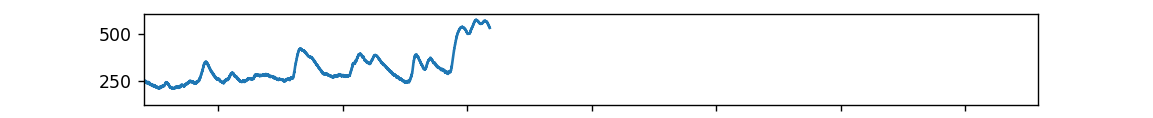

In [16]:
# zoomed plot
plot_timeseries('Mainz')

In [17]:
# in the github file I have cleared the output of this cell
pred = predict('Mainz', 48)

Train on 369243 samples, validate on 41027 samples
Epoch 1/10
369243/369243 [==============================] - 9s 24us/sample - loss: 0.0011 - val_loss: 7.8685e-05
Epoch 2/10
369243/369243 [==============================] - 8s 23us/sample - loss: 5.8966e-05 - val_loss: 4.0065e-05
Epoch 3/10
369243/369243 [==============================] - 8s 21us/sample - loss: 3.4373e-05 - val_loss: 3.1093e-05
Epoch 4/10
369243/369243 [==============================] - 8s 22us/sample - loss: 2.9933e-05 - val_loss: 2.8679e-05
Epoch 5/10
369243/369243 [==============================] - 7s 18us/sample - loss: 2.8168e-05 - val_loss: 2.7487e-05
Epoch 6/10
369243/369243 [==============================] - 7s 20us/sample - loss: 2.7134e-05 - val_loss: 2.7283e-05
Epoch 7/10
369243/369243 [==============================] - 7s 18us/sample - loss: 2.6309e-05 - val_loss: 2.5441e-05
Epoch 8/10
369243/369243 [==============================] - 6s 17us/sample - loss: 2.5531e-05 - val_loss: 2.4717e-05
Epoch 9/10
369243

369243/369243 [==============================] - 7s 18us/sample - loss: 2.7665e-05 - val_loss: 2.6473e-05
Epoch 6/10
369243/369243 [==============================] - 7s 18us/sample - loss: 2.7231e-05 - val_loss: 2.6539e-05
Epoch 7/10
369243/369243 [==============================] - 7s 18us/sample - loss: 2.7050e-05 - val_loss: 2.4799e-05
Epoch 8/10
369243/369243 [==============================] - 7s 18us/sample - loss: 2.6357e-05 - val_loss: 2.4073e-05
Epoch 9/10
369243/369243 [==============================] - 7s 18us/sample - loss: 2.6676e-05 - val_loss: 2.3928e-05
Epoch 10/10
369243/369243 [==============================] - 7s 18us/sample - loss: 2.5618e-05 - val_loss: 2.3977e-05
Train on 369243 samples, validate on 41027 samples
Epoch 1/10
369243/369243 [==============================] - 8s 21us/sample - loss: 0.0187 - val_loss: 1.8354e-04
Epoch 2/10
369243/369243 [==============================] - 6s 18us/sample - loss: 9.3189e-05 - val_loss: 4.4035e-05
Epoch 3/10
369243/369243 [=

369243/369243 [==============================] - 6s 17us/sample - loss: 3.2837e-05 - val_loss: 3.0164e-05
Epoch 10/10
369243/369243 [==============================] - 6s 17us/sample - loss: 2.9673e-05 - val_loss: 2.7974e-05
Train on 369243 samples, validate on 41027 samples
Epoch 1/10
369243/369243 [==============================] - 4s 12us/sample - loss: 7.4093e-04 - val_loss: 6.5890e-05
Epoch 2/10
369243/369243 [==============================] - 3s 9us/sample - loss: 4.9236e-05 - val_loss: 3.7912e-05
Epoch 3/10
369243/369243 [==============================] - 3s 9us/sample - loss: 3.5164e-05 - val_loss: 3.2750e-05
Epoch 4/10
369243/369243 [==============================] - 3s 9us/sample - loss: 3.2092e-05 - val_loss: 3.0528e-05
Epoch 5/10
369243/369243 [==============================] - 3s 9us/sample - loss: 3.0367e-05 - val_loss: 3.0119e-05
Epoch 6/10
369243/369243 [==============================] - 3s 9us/sample - loss: 2.8747e-05 - val_loss: 2.7405e-05
Epoch 7/10
369243/369243 [==

369243/369243 [==============================] - 5s 13us/sample - loss: 3.3480e-05 - val_loss: 3.1080e-05
Epoch 4/10
369243/369243 [==============================] - 5s 13us/sample - loss: 3.0078e-05 - val_loss: 3.0593e-05
Epoch 5/10
369243/369243 [==============================] - 5s 13us/sample - loss: 2.8009e-05 - val_loss: 2.6317e-05
Epoch 6/10
369243/369243 [==============================] - 5s 13us/sample - loss: 2.6915e-05 - val_loss: 2.9630e-05
Epoch 7/10
369243/369243 [==============================] - 5s 13us/sample - loss: 2.6963e-05 - val_loss: 2.4353e-05
Epoch 8/10
369243/369243 [==============================] - 5s 13us/sample - loss: 2.6012e-05 - val_loss: 2.5832e-05
Epoch 9/10
369243/369243 [==============================] - 5s 13us/sample - loss: 2.6471e-05 - val_loss: 2.8640e-05
Epoch 10/10
369243/369243 [==============================] - 5s 13us/sample - loss: 2.5644e-05 - val_loss: 2.7066e-05
Train on 369243 samples, validate on 41027 samples
Epoch 1/10
369243/36924

369243/369243 [==============================] - 5s 15us/sample - loss: 2.8230e-05 - val_loss: 2.6199e-05
Epoch 8/10
369243/369243 [==============================] - 5s 14us/sample - loss: 2.7234e-05 - val_loss: 2.6716e-05
Epoch 9/10
369243/369243 [==============================] - 5s 14us/sample - loss: 2.6570e-05 - val_loss: 2.9635e-05
Epoch 10/10
369243/369243 [==============================] - 5s 15us/sample - loss: 2.6202e-05 - val_loss: 2.5364e-05
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 1, 64)             20480     
_________________________________________________________________
dense_108 (Dense)            (None, 1, 16)             1040      
_________________________________________________________________
dense_109 (Dense)            (None, 1, 1)              17        
Total params: 21,537
Trainable params: 21,537
Non-trainab

In [18]:
pred

{'optimal_parameters': {'lstm_units': 64,
  'hidden_dense_layers': 1,
  'dense_units': 16,
  'act_fct': 'linear'},
 'train_loss': 2.5274178315304524e-05,
 'test_loss': 2.570485759481075e-05,
 'last_observed_city_level': 534.0,
 'the_prediction': array([[[516.04675]]], dtype=float32)}